# Приоритизация гипотез и анализ результатов A/B-теста

**Цель проекта:** подготовить список гипотез для увеличения выручки и проанализировать результаты A/B-теста.

**Задачи проекта:** 
- приоритезировать гипотезы и подготовить список для проверки
- запустить A/B-тест
- проанализировать результаты A/B-теста (визуализировать данные, посчитать статистическую значимость и перцентили стоимости заказов, принять решение по результатам теста)

**Описание данных:** у нас есть данные интернет-магазина о заказах, проведенных тестах и гипотезах.

#### Содержание наборов данных:

Файл **/datasets/hypothesis.csv**. Скачать датасет
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл **/datasets/orders.csv**. Скачать датасет
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл **/datasets/visitors.csv**. Скачать датасет
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

#### План анализа:
- Обзор и подготовка данных (анализ и обработка ошибок)
- Приоритизация гипотез
- Анализ A/B-теста
- Итоговый вывод и принятие решение по результатам теста

### Оглавление

1. [Обзор и подготовка данных](#one) </n>
2. [Приоритизация гипотез](#three)
3. [Анализ A/B-теста](#four)
4. [Итоговый вывод](#five)

---

# <a id="one"> Обзор и подготовка данных</a>

In [1]:
#импорт библиотек
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
import scipy.stats as stats
import datetime as dt
import numpy as np

#сохраняем таблицы в переменных
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

### Информация о гипотезах

In [2]:
hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


### Комментарий

Таблица содержит коррентные данные, здесь 9 гипотез по увеличению выручки интернет-магазина. В стобцах указаны параметры Reach, Impact, Confidence, Effort. Информация из нее поможет нам в работе с фреймворками ICE и RICE.

---

### Информация о заказах

In [3]:
orders.info()
orders.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [4]:
# исправим тип данных для столбца с датами
orders['date'] = pd.to_datetime(orders['date'], format='%Y.%m.%d')

### Комментарий

В таблице 1196 значений — 557 значений в группе А, 640 значений в группе B. Данные собирались с 2019-08-01 до 2019-08-31 — тип данных для столбца с датами исправлен.

---

### Информация о посетителях и тесте

In [5]:
visitors.info()
visitors.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [6]:
# исправим тип данных для столбца с датами
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y.%m.%d')

### Комментарий

Мы исправили тип данных для столбца с датами. В таблице 62 значения. Мы видим с количество пользователей в указанную дату для каждого вариант теста.

---

# <a id="three"> Приоритизация гипотез</a>

### Оглавление раздела

1. [Фреймворк ICE](#step1) </n>
2. [Фреймворк RICE](#step2)

Нам нужно приоритезировать гипотезы для того, чтобы в будущем мы смогли максимизировать улучшение ключевых метрик. Для проверки мы воспользуемся одними из самых популярных способов проритезации гипотез — метод ICE и его модификация RICE.

Для проверки нам понадобится таблица hypothesis, где собраны важные показатели для рассчета.

In [7]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


# <a id="step1"> Фреймворк ICE</a>

In [8]:
hypothesis['ICE'] = (hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts']
hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


## Комментарий

Наиболее перспективные гипотезы по ICE под номерами: 8, 0, 7.

- 8 — Запустить акцию, дающую скидку на товар в день рождения
- 0 — Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- 7 — Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

---

# <a id="step2"> Фреймворк RICE</a>

In [9]:
hypothesis['RICE'] = (hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts']
hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


## Комментарий

Среди наиболее перспективных гипотеза по RICE можно отмеить: 7, 2, 0, 6

- 7 — Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- 2 — Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- 0 — Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- 6 — Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

## Промежуточный вывод

Гипотезы 0 и 7 оказались лидирующими в двух проверках, однако другие не совпали. Такое может произойти, если параметр Reach (охват пользователей) имеет большое значение. Например, во второй гипотезе Reach равен 8.

В целом 0 и 7 — наиболее приоритетные, а после можно отметить гипотезы 0, 2 и 8, так как именно эти пять гипотез были первыми в обоих случаях.

---

# <a id="four"> Анализ A/B-теста</a>

### Оглавление раздела

1. [Кумулятивная выручка по группам](#step3) </n>
2. [Кумулятивный средний чек по группам](#step4)
3. [Относительные изменения кумулятивного среднего чека по группам](#step5)
4. [Кумулятивная конверсия по группам](#step6)
5. [Относительные изменения кумулятивной конверсии по группам](#step7)
6. [Количества заказов по пользователям](#step8)
7. [Количество и стоимость заказов, подсчет перцентилей](#step9)
8. [Статистическая значимость различий для разных показателей](#step10)

Для анализа нам понадобятся две таблицы orders и visitors.

In [10]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [11]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


# <a id="step3"> Кумулятивная выручка по группам</a>

Изучим график кумулятивных, или накапливаемых данных.

In [12]:
# создаем таблицу с уникальными парами значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [13]:
# соберём агрегированные кумулятивные по дням данные о заказах

# соберем строки таблицы orders, чья дата меньше или равна дате элемента из datesGroups
# при этом учитывая группу тесте из datesGroups
# вычислим максимальную дату и максимум для группы, чтобы столбец с ними не пропал
# найдём число уникальных ID заказов и пользователей с помощью nunique 
# подсчитаем сумму средних чеков
# применим методы к каждой строке с помощью apply и отсортируем результаты по столбцам 'date' и 'group':
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# аналогично получим агрегированные кумулятивные данные о посетителях интернет-магазина  по дням 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])


In [14]:
# объединяем кумулятивные данные в одной таблице и переименуем столбцы
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

Построим графики кумулятивной выручки по дням и группам

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


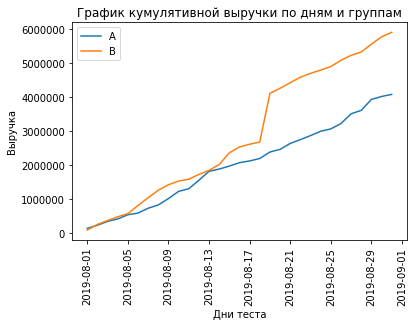

In [15]:
# таблица с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# таблица с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=90) 
plt.title('График кумулятивной выручки по дням и группам')
plt.xlabel('Дни теста')
plt.ylabel('Выручка')
plt.legend();

## Комментарий

Выручка увеличивается на протяжении всего теста. График группы В резко вырос между 17 и 21 августа, что может означать, что в этот период произошел всплеск заказов или появление выбросов в виде слишком дорогих заказов. Нужно будет проанализировать эти выбросы дальше.

----

# <a id="step4"> Кумулятивный средний чек по группам</a>

Теперь построим график кумулятивного среднего чека по группам, для чего разделим кумулятивную выручку на кумулятивное число заказов.

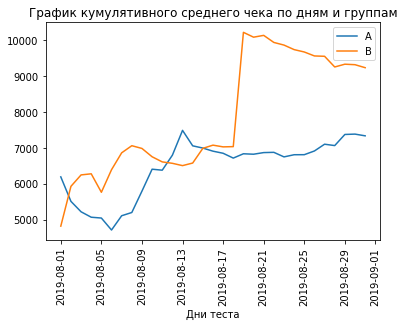

In [37]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.xticks(rotation=90) 
plt.title('График кумулятивного среднего чека по дням и группам')
plt.xlabel('Дни теста')
plt.legend();

## Комментарий

Средний чек становится равномерным примерно посел 17 августа, где мы опять же видим резкий всплеск для группы В. При это для группы В он начал снижаться, а для группы А расти. 

Выброс для группы В мог повлиять на результаты, так что можно предположить, что ей нужно больше данных, чтобы определить реальный средний чек и установиться на его уровне.

---

# <a id="step5"> Относительные изменения кумулятивного среднего чека по группам</a>

Теперь остроим график относительного различия для среднего чека.

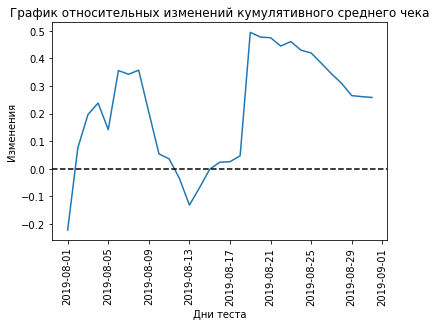

In [17]:
# объединим таблицы
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# построим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавим ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.xticks(rotation=90) 
plt.title('График относительных изменений кумулятивного среднего чека')
plt.xlabel('Дни теста')
plt.ylabel('Изменения');

## Комментарий

Мы видим, что в нескольких точках график различия резко меняется между сегментами. Это опять же говорит нам о том, что в данных были выбросы — нужно проверить были ли крупные заказы.

---

# <a id="step6"> Кумулятивная конверсия по группам</a>

Теперь построим и проанализируем график кумулятивной конверсии. 

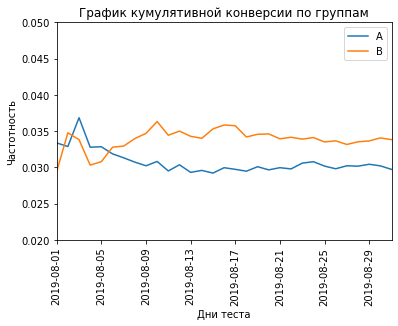

In [18]:
# посчитаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделим данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
# отделим данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# построим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.xticks(rotation=90) 
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дни теста')
plt.ylabel('Частотность')
plt.legend()

# задаем масштаб осей
plt.axis(["2019-08-01", '2019-08-31', 0.02, 0.05]);

## Комментарий

Мы видим, что в начале теста данные по двум группам были близко друг к другу и держались между 0.30 и 0.37. К концу теста конверсия группы В стала больше и зафиксировалась, а конверсия группы А просела и таже зафиксировалась.

Конверсии значительно отличаются друг от друга.

---

# <a id="step7"> Относительные изменения кумулятивной конверсии по группам</a>

Построим график относительного различия кумулятивных конверсий.

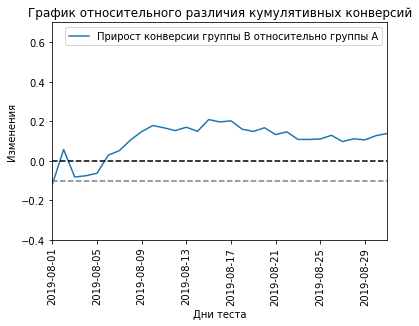

In [19]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', right_on='date', 
                                                                           how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/
         mergedCumulativeConversions['conversionA']-1, label="Прирост конверсии группы B относительно группы A")

plt.xticks(rotation=90) 
plt.title('График относительного различия кумулятивных конверсий')
plt.xlabel('Дни теста')
plt.ylabel('Изменения')
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.4, 0.7]);


## Комментарий

Группа В растет и постепенно устанавливается. К концу теста мы можем зафиксировать рост. Обзор аномалий поможет нам более точно сделать выводы.

Относительное изменение конверсии группы B уже достаточно долгое время больше 0

---

# <a id="step8"> Количества заказов по пользователям</a>

Подсчитаем количество заказов и построим точечный график.

In [20]:
# сгруппируем данные, изменим названия столбцов и отсортируем по количеству заказов
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})

ordersByUsers.columns = ['visitorId','orders']

ordersByUsers.sort_values(by='orders',ascending=False).head(10)

,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


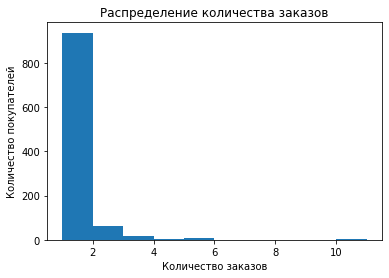

In [21]:
plt.hist(ordersByUsers['orders'])

plt.title('Распределение количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Количество покупателей')
plt.show();

## Комментарий

Есть пользователи, которые совершали 11, 9, 8 и 5 заказов, что значительно больше, чем совершает в среднем пользователь за неделю. При этом большинство совершило не больше двух заказов.

Построим точечную диаграмму количества заказов на одного пользователя.

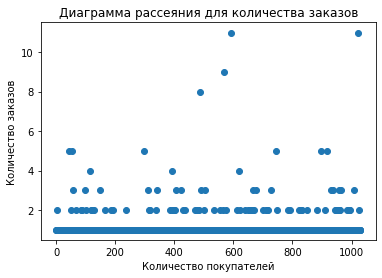

In [22]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])

plt.title('Диаграмма рассеяния для количества заказов')
plt.xlabel('Количество покупателей')
plt.ylabel('Количество заказов')
plt.show();

## Комментарий

Точечная диаграмма подтвердила: много пользователей совершают 2-4 покупки. При этом видны редкие показатели с 7-10 заказами, их мало. Точная доля пользователей пока непонятна, а значит неизвестно можно ли считать их аномалиями.

---

# <a id="step9"> Количество и стоимость заказов, подсчет перцентилей</a>

Посчитаем выборочные перцентили количества заказов на одного пользователя и выберем границу для определения аномальных пользователей.

In [23]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 2., 4.])

## Комментарий

Не более 5% пользователей оформляли больше чем 2 заказа. И 10% пользователей заказывали более одного раза.

Разумно выбрать 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.

Построим точечный график стоимостей заказов.

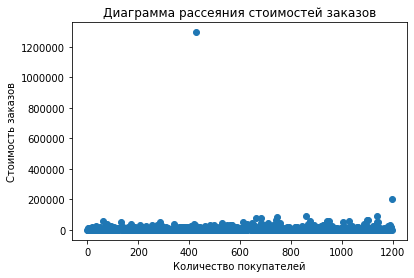

In [24]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.title('Диаграмма рассеяния стоимостей заказов')
plt.xlabel('Количество покупателей')
plt.ylabel('Стоимость заказов')
plt.show();

## Комментарий

Теперь мы точно видим, что есть пара дорогих заказов, один из которых дороже 1 200 000. По графику можно выбрать границу аномальных заказов между 200 000 и 400 000 рублей, но принято отсеивать от 1% до 5% наблюдений с крайними значениями. Поэтому посчитаем 95-й и 99-й перцентили стоимости заказов, чтобы выбрать границу для определения аномальных заказов.

In [25]:
np.percentile(orders['revenue'], [95, 97.5, 99])

array([28000. , 39530. , 58233.2])

## Комментарий

Не более 5% заказов дороже 28000 рублей и не более 1% дороже 58233 рублей. Будем использовать эти показатели для фильтрации дальше.

---

# <a id="step10"> Статистическая значимость различий для разных показателей</a>

### Статистическая значимость различий в конверсии между группами по «сырым» данным

Сформулируем гипотезу для проверки:

- Нулевая гипотеза: в конверсии между группами нет статистических различий.
- Альтернативная гипотеза: в конверсии между группами есть статистические различия

Изучим и обработаем код для рассчета.

In [26]:
# отберем данные по группе А
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# отберем данные по группе А
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [27]:
# повторим последовательность, которую использовали выше (отбираем по группам, группируем и аггрегируем)
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

In [28]:
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [29]:
# объединими все необходимые данные в одну таблицу
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

Посчитаем статистическую значимость различия в конверсии между группами.

In [30]:
# создадим переменные ordersByUsersA и ordersByUsersB 
# здесь определим для пользователей число совершенных заказов
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

In [31]:
# объединми по строкам с помощью pd.concat

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)


In [32]:
# выведем относительный прирост конверсии и округлим до трёх знаков после запятой

display("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
display("{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))


'0.00840'

'0.138'

## Комментарий
Первое число p-value значительно меньше 0.05, потому нулевую гипотезу можно отвергнуть. Анализ сырых данных показывает, что в конверсии между группами есть статистические различия.

Относительный прирост конверсии группы В к конверсии группы А равен 13,8%.

---

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезу для проверки:

- Нулевая гипотеза: значимых отличий в среднем чеке между группами нет
- Альтернативная гипотеза: значимые отличия в среднем чеке между группами есть

Также найдём относительные различия в среднем чеке между группами.

In [33]:
display("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
display("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))


'0.365'

'0.259'

## Комментарий

Не отвергаем нулевую гипотезу — P-value больше 0.05 — значимых отличий в среднем чеке между группами нет. При этом относительное различие среднего чека между сегментами 25%, а это не мало.

### Статистическая значимость различий в конверсии между группами по «очищенным» данным

Сформулируем гипотезу для проверки:

- Нулевая гипотеза: в конверсии между группами по «очищенным» данным нет статистических различий.
- Альтернативная гипотеза: в конверсии между группами по «очищенным» данным есть статистические различия

Удалим аномалии и посчитаем статистическую значимость. Для этого узнаем, сколько всего аномальных пользователей. Выше мы определили, что 95-й и 99-й перцентили средних чеков равны 28000 и 58233 рублям.  А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказам на пользователя.

Примем за аномальных пользователей тех, кто совершил больше двух заказов или совершмл заказ дороже 30 тысяч. Так мы уберём 5% пользователей с наибольшим числом заказов или с аномально дорогими заказами. Сделаем срезы пользователей.

In [34]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'], ordersByUsersB[ordersByUsersB['orders'] > 4]['visitorId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
display(abnormalUsers.head(5))
display(abnormalUsers.shape)


1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
Name: visitorId, dtype: int64

(62,)

В данных 62 аномальных пользователя. Теперь посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным.

In [35]:
# подготовим выборки количества заказов по пользователям по группам теста
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

# применим статистический критерий Манна-Уитни
display("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
display("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))


'0.006'

'0.203'

P-value все еще значительно меньше 0.05. Относительный прирост конверсии группы В к конверсии группы А увеличисля и теперь равен 20.3%.

Проверим изменились ли результаты по среднему чеку.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем гипотезу для проверки:

- Нулевая гипотеза: значимых отличий в среднем чеке по «очищенным» данным между группами нет
- Альтернативная гипотеза: значимые отличия в среднем чеке по «очищенным» данным между группами есть

In [36]:
# по группе А
display("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

# по группе В
display("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))


'0.383'

'-0.021'

## Комментарий

P-value уменьшился, а разница между сегментами сократилась с 25% до 2%, что уже очень значительно.

Интересно, что после очистки от выбросов значимость критериев не изменилась, в то время как относительное изменение среднего чека уменьшилось в 10 раз.

## Промежуточный вывод


- Анализ сырых данных показывает, что **в конверсии между группами есть статистические различия**. Относительный прирост конверсии группы В к конверсии группы А равен 20.3% после фильтрации аномалий.


- Значимых **отличий в среднем чеке между группами нет**. При этом относительное различие среднего чека между сегментами 2% после фильтрации аномалий.


- График различия конверсии между группами сообщает, что результаты группы B улучшаются, и к концу теста заметен стабильный рост.
- График различия среднего чека говорит о том, что результаты группы B ухудшаются с каждым днем.

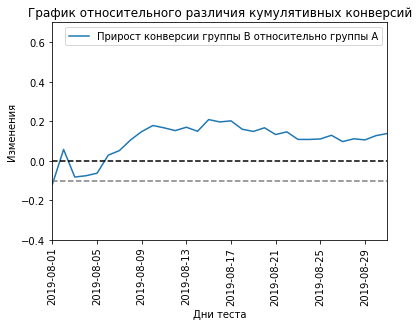

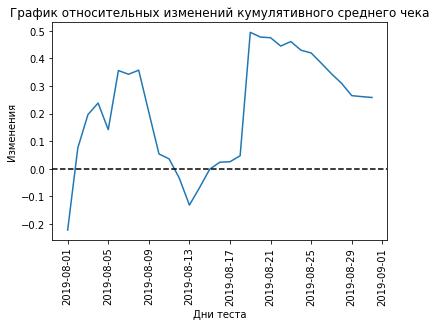

## Принятие решения на основе данных

На графиках кумулятивных показателей мы видим, что показатели группы В значительно выше группы А, но мы обнаружили всплеск, который мог повлиять на результат.

График различия конверсии между группами сообщает, что результаты группы B улучшаются, и к концу теста заметен стабильный рост. Конверсии группы В к конверсии группы А равен 20.3% после фильтрации аномалий, есть статистические различия.

График различия среднего чека говорит о том, что результаты группы B ухудшаются с каждым днем. Отличий в среднем чеке между группами нет. При этом относительное различие среднего чека между сегментами 2% после фильтрации аномалий.

Из-за показателей по конверсии можно сделать вывод, что есть вероятность того, что показатели группы В могут улучшаться, тест можно продолжить, чтобы убедиться в том, что группа В действительно показывает лучший результат.

---

# <a id="five"> Итоговый вывод</a>

## Проверка гипотез

Гипотезы 0 и 7 оказались лидирующими в двух проверках, а после можно отметить гипотезы 0, 2 и 8, так как именно эти пять гипотез были первыми в обоих случаях.

## Анализ A/B-теста

### Выбросы

Выручка увеличивается на протяжении всего теста. Средний чек становится равномерным примерно посел 17 августа. График группы В резко вырос между 17 и 21 августа, что может означать, что в этот период произошел всплеск заказов или появление выбросов в виде слишком дорогих заказов.

Мы видим, что в нескольких точках график различия резко меняется между сегментами. Это опять же говорит нам о том, что в данных были выбросы — нужно проверить были ли крупные заказы. 

### Общие замечания

Не более 5% пользователей оформляли больше, чем 2 заказа. И 10% пользователей заказывали более одного раза.

Точечная диаграмма подтвердила: много пользователей совершают 2-4 покупки.

В данный есть аномально большие заказы, которые влияют на результат: один из них стоил 1 200 000 рублей.

### Вывод по графикам

К концу теста конверсия группы В стала больше и зафиксировалась, а конверсия группы А просела и таже зафиксировалась. Группа В растет и постепенно устанавливается. К концу теста мы можем зафиксировать рост.

На графиках кумулятивных показателей мы видим, что показатели группы В значительно выше группы А, но мы обнаружили всплеск, который мог повлиять на результат.

График различия конверсии между группами сообщает, что результаты группы B улучшаются, и к концу теста заметен стабильный рост. Конверсии группы В к конверсии группы А равен 20.3% после фильтрации аномалий, есть статистические различия.

График различия среднего чека говорит о том, что результаты группы B ухудшаются с каждым днем. Отличий в среднем чеке между группами нет. При этом относительное различие среднего чека между сегментами 2% после фильтрации аномалий.

Из-за показателей по конверсии можно сделать вывод, что есть вероятность того, что показатели группы В могут улучшаться, тест можно продолжить, чтобы убедиться в том, что группа В действительно показывает лучший результат.